In [103]:
import os
import matplotlib.pyplot as plt
from stompy import utils
import pandas as pd
import numpy as np
import xarray as xr
from stompy.grid import unstructured_grid
from stompy.model.fish_ptm import ptm_tools
%matplotlib notebook

In [16]:
ptm_run_dir="test_basic/"
hydro_file="/opt/sfb_ocean/suntans/runs/merge_005-20170610avg-retry/average.nc_0000.nc"

In [47]:
hydro=xr.open_dataset(hydro_file)
grid=unstructured_grid.UnstructuredGrid.from_ugrid(hydro)

In [112]:
bin_file=ptm_tools.PtmBin(os.path.join(ptm_run_dir,'INIT_NOK_bin.out'))

In [113]:
bin_file.count_timesteps()

289

In [114]:
dnum,particles=bin_file.read_timestep(60)
print(dnum)

2017-06-18 05:00:00


<IPython.core.display.Javascript object>


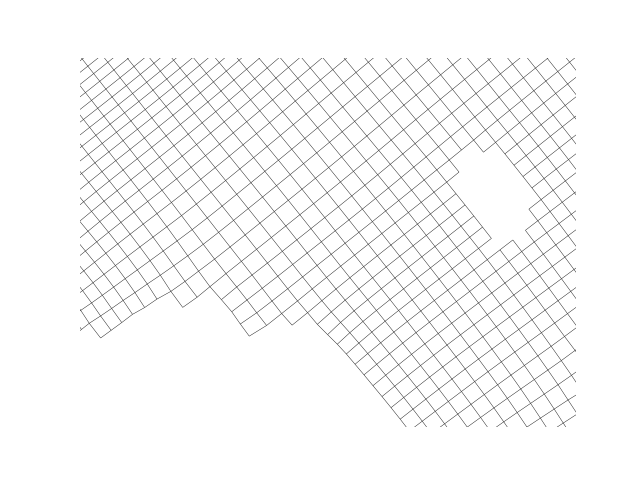

In [109]:
# zoom=(492273., 584318, 4157899., 4226487.)
#zoom=(543109., 549115., 4183563, 4188039.)
zoom=[548658., 556644., 4182827., 4188778]
fig=plt.figure()
ax=fig.add_subplot(1,1,1)

grid.plot_edges(color='k',facecolor='0.7',lw=0.3,ax=ax,zorder=-2)

vel_points=np.array([[546265,4185860],
                     [553367,4185870]])
cells=[grid.select_cells_nearest(vel_pnt) for vel_pnt in vel_points]
          
          
ktop=3    
    
def set_timestep(i):
    dnum,particles=bin_file.read_timestep(i)
    ax.lines=[]
    del ax.collections[1:]
    sel=slice(None) # particles['x'][:,2]>-7 # only surface
    scal=particles['id']
    # scal=particles['x'][:,2]
    ax.scatter(particles['x'][sel,0],
               particles['x'][sel,1],
               7,scal,cmap='jet')
    avg_idx=np.searchsorted(hydro.time,utils.to_dt64(dnum))
    U=hydro.uc.isel(Nk=ktop,Nc=cells,time=avg_idx)
    V=hydro.vc.isel(Nk=ktop,Nc=cells,time=avg_idx)
    quiv=ax.quiver(vel_points[:,0],vel_points[:,1],
                   U.values,V.values,
                   scale_units='xy',angles='xy',scale=0.0005,zorder=3)
ax.axis(zoom)
set_timestep(1)

In [110]:
for i in range(bin_file.count_timesteps()):
    set_timestep(i)
    fig.canvas.draw()
    plt.pause(0.1)
    


KeyboardInterrupt: 

In [86]:
dnum

datetime.datetime(2017, 6, 11, 15, 0)

In [98]:
particles

array([(    1, [ 5.46178545e+05,  4.18670977e+06, -1.73950509e+01], 1),
       (    2, [ 5.40190756e+05,  4.18301324e+06, -3.60956551e+00], 1),
       (    3, [ 5.45150758e+05,  4.18637984e+06, -1.12108047e+01], 1),
       ...,
       (13897, [ 5.48942393e+05,  4.18638783e+06, -2.40044326e+01], 1),
       (13898, [ 5.49881641e+05,  4.18694508e+06, -2.84569114e+01], 1),
       (13899, [ 5.50426720e+05,  4.18670215e+06, -1.28118028e+01], 1)],
      dtype=[('id', '<i4'), ('x', '<f8', (3,)), ('active', '<i4')])

In [118]:
group='FIXSURF'
bin_file=ptm_tools.PtmBin(os.path.join(ptm_run_dir,group+'_bin.out'))

data_dir="csvs-"+group
os.path.exists(data_dir) or os.mkdir(data_dir)

ptm_data=[bin_file]

for step in utils.progress(range(bin_file.count_timesteps())):
    fn=os.path.join(data_dir,"combined_%04d.csv"%step)
    #if os.path.exists(fn): continue

    dfs=[]
    for src_i,src in enumerate(ptm_data):
        t,parts=src.read_timestep(step)
        sel=np.ones( len(parts), np.bool8 )
        #for dp in dead_paths:
        #    sel &= ~dp.contains_points(parts['x'][:,:2])

        df=pd.DataFrame()
        df['x']=parts['x'][sel,0]
        df['y']=parts['x'][sel,1]
        df['z']=parts['x'][sel,2]
        df['group']=src_i
        dfs.append(df)

    comb=pd.concat(dfs)
    comb.to_csv(fn,index=False,float_format="%.1f")


INFO:utils:76/241
INFO:utils:151/241
INFO:utils:228/241
